# Prédiction des retards de vols et recommander le déploiement fonctionnel de ce modèle pour leurs clients

In [2]:
import sqlite3
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt 
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In [3]:
# Create your connection
cnx = sqlite3.connect(r'C:\Users\33627\Documents\IMSD 2019-2020\IMSD S2\CRM\batch_1.db')

## La table vols

In [4]:
df_vols = pd.read_sql_query("SELECT * FROM vols", cnx)
df_vols.head()

,IDENTIFIANT,VOL,CODE AVION,AEROPORT DEPART,AEROPORT ARRIVEE,DEPART PROGRAMME,HEURE DE DEPART,RETART DE DEPART,TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE,DECOLLAGE,...,ANNULATION,RAISON D'ANNULATION,RETARD SYSTEM,RETARD SECURITE,RETARD COMPAGNIE,RETARD AVION,RETARD METEO,DATE,NIVEAU DE SECURITE,COMPAGNIE AERIENNE
0,651373,2317,28fa5df4d7,TIA,DSS,1410,1411.0,1.0,20.0,1431.0,...,0,None,NaN,NaN,NaN,NaN,NaN,10/4/2016,10,NVPPA
1,4153042,1755,4b31cd6358,MPM,BOH,1455,1449.0,-6.0,15.0,1504.0,...,0,None,NaN,NaN,NaN,NaN,NaN,16/7/2018,10,COA
2,3617513,804,f3e0769c08,TRN,TNA,1540,1607.0,27.0,9.0,1616.0,...,0,None,NaN,NaN,NaN,NaN,NaN,6/1/2018,10,NA
3,1829601,263,2ba258e5c4,BRU,SXF,2226,2219.0,-7.0,14.0,2233.0,...,0,None,NaN,NaN,NaN,NaN,NaN,9/1/2016,10,THA
4,1250864,4511,11e7ffe99f,VCE,AAL,1730,1719.0,-11.0,14.0,1733.0,...,0,None,NaN,NaN,NaN,NaN,NaN,23/1/2016,10,MAF


In [5]:
df_vols.columns

Index(['IDENTIFIANT', 'VOL', 'CODE AVION', 'AEROPORT DEPART',
       'AEROPORT ARRIVEE', 'DEPART PROGRAMME', 'HEURE DE DEPART',
       'RETART DE DEPART', 'TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE',
       'DECOLLAGE', 'TEMPS PROGRAMME', 'TEMPS PASSE', 'TEMPS DE VOL',
       'DISTANCE', 'ATTERRISSAGE',
       'TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE', 'ARRIVEE PROGRAMMEE',
       'HEURE D'ARRIVEE', 'RETARD A L'ARRIVEE', 'DETOURNEMENT', 'ANNULATION',
       'RAISON D'ANNULATION', 'RETARD SYSTEM', 'RETARD SECURITE',
       'RETARD COMPAGNIE', 'RETARD AVION', 'RETARD METEO', 'DATE',
       'NIVEAU DE SECURITE', 'COMPAGNIE AERIENNE'],
      dtype='object')

In [6]:
df_vols.shape

(3000000, 30)

## La table aeroports

In [21]:
df_aeroports = pd.read_sql_query("SELECT * FROM aeroports", cnx)
df_aeroports.head()

,CODE IATA,NOM,LIEU,PAYS,LONGITUDE,LATITUDE,HAUTEUR,PRIX RETARD PREMIERE 10 MINUTES,PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES
0,MCT,Muscat International Airport,Muscat,OM,58.284400939941406,23.593299865722656,48.0,6695,361
1,SOU,Southampton Airport,Southampton,GB,-1.3567999601364136,50.95029830932617,44.0,1061,71
2,PNH,Phnom Penh International Airport,Phnom Penh,KH,104.84400177001953,11.546600341796875,40.0,2402,909
3,BLR,Kempegowda International Airport,Bangalore,IN,77.706299,13.1979,3000.0,8641,550
4,FFD,RAF Fairford,Fairford,GB,-1.7900300025900002,51.6822013855,286.0,6883,870


In [8]:
df_aeroports.columns

Index(['CODE IATA', 'NOM', 'LIEU', 'PAYS', 'LONGITUDE', 'LATITUDE', 'HAUTEUR',
       'PRIX RETARD PREMIERE 10 MINUTES',
       'PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES'],
      dtype='object')

In [9]:
df_aeroports.shape

(321, 9)

## La table compagnies

In [10]:
df_compagines = pd.read_sql_query("SELECT * FROM compagnies", cnx)
df_compagines.head()

,COMPAGNIE,CODE
0,Try Hard Airlines,THA
1,Corporate Overlord Airways,COA
2,Neverland Airlines,NA
3,Always A Problem Flights,AAPF
4,Overpriced Air,OA


In [11]:
df_compagines.shape

(13, 2)

## Merger les fichiers 

### Garder les colonnes utiles pour le fichier aeroports

In [9]:
col_to_keep = ['CODE IATA', 
               'PRIX RETARD PREMIERE 10 MINUTES', 
               'PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES']

df_aeroports = df_aeroports[col_to_keep]

In [10]:
retart_10_min = df_aeroports.iloc[:,:-1].set_index(
        'CODE IATA').to_dict()['PRIX RETARD PREMIERE 10 MINUTES']

In [11]:
retart_apres_10_min = df_aeroports.loc[:,['CODE IATA',
        'PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES']].set_index(
        'CODE IATA').to_dict()['PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES']

### Appliquer les calculs dans le fichiers vols

In [12]:
df_vols["PRIX_DEP_RP_10MIN"] = df_vols['AEROPORT DEPART'].apply(lambda x : retart_10_min[x])
df_vols["PRIX_ARIV_RP_10MIN"] = df_vols['AEROPORT ARRIVEE'].apply(lambda x : retart_10_min[x])

In [13]:
df_vols["PRIX_DEP_RCMA_10MIN"] = df_vols['AEROPORT DEPART'].apply(lambda x : retart_apres_10_min[x])
df_vols["PRIX_ARIV_RCMA_10MIN"] = df_vols['AEROPORT ARRIVEE'].apply(lambda x : retart_apres_10_min[x])
df_vols.shape

(2940415, 34)

In [18]:
df_vols.head()

,IDENTIFIANT,VOL,CODE AVION,AEROPORT DEPART,AEROPORT ARRIVEE,DEPART PROGRAMME,HEURE DE DEPART,RETART DE DEPART,TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE,DECOLLAGE,...,RETARD COMPAGNIE,RETARD AVION,RETARD METEO,DATE,NIVEAU DE SECURITE,COMPAGNIE AERIENNE,PRIX_DEP_RP_10MIN,PRIX_ARIV_RP_10MIN,PRIX_DEP_RCMA_10MIN,PRIX_ARIV_RCMA_10MIN
0,651373,2317,28fa5df4d7,TIA,DSS,1410,1411.0,1.0,20.0,1431.0,...,NaN,NaN,NaN,10/4/2016,10,NVPPA,4582,5499,586,120
1,4153042,1755,4b31cd6358,MPM,BOH,1455,1449.0,-6.0,15.0,1504.0,...,NaN,NaN,NaN,16/7/2018,10,COA,4778,3147,12,278
2,3617513,804,f3e0769c08,TRN,TNA,1540,1607.0,27.0,9.0,1616.0,...,NaN,NaN,NaN,6/1/2018,10,NA,352,2066,849,795
3,1829601,263,2ba258e5c4,BRU,SXF,2226,2219.0,-7.0,14.0,2233.0,...,NaN,NaN,NaN,9/1/2016,10,THA,5077,2151,48,685
4,1250864,4511,11e7ffe99f,VCE,AAL,1730,1719.0,-11.0,14.0,1733.0,...,NaN,NaN,NaN,23/1/2016,10,MAF,2143,8346,434,353


In [19]:
df_vols.columns

Index(['IDENTIFIANT', 'VOL', 'CODE AVION', 'AEROPORT DEPART',
       'AEROPORT ARRIVEE', 'DEPART PROGRAMME', 'HEURE DE DEPART',
       'RETART DE DEPART', 'TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE',
       'DECOLLAGE', 'TEMPS PROGRAMME', 'TEMPS PASSE', 'TEMPS DE VOL',
       'DISTANCE', 'ATTERRISSAGE',
       'TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE', 'ARRIVEE PROGRAMMEE',
       'HEURE D'ARRIVEE', 'RETARD A L'ARRIVEE', 'DETOURNEMENT', 'ANNULATION',
       'RAISON D'ANNULATION', 'RETARD SYSTEM', 'RETARD SECURITE',
       'RETARD COMPAGNIE', 'RETARD AVION', 'RETARD METEO', 'DATE',
       'NIVEAU DE SECURITE', 'COMPAGNIE AERIENNE', 'PRIX_DEP_RP_10MIN',
       'PRIX_ARIV_RP_10MIN', 'PRIX_DEP_RCMA_10MIN', 'PRIX_ARIV_RCMA_10MIN'],
      dtype='object')

In [20]:
df_vols.isnull().sum()

IDENTIFIANT                                            0
VOL                                                    0
CODE AVION                                             0
AEROPORT DEPART                                        0
AEROPORT ARRIVEE                                       0
DEPART PROGRAMME                                       0
HEURE DE DEPART                                    49226
RETART DE DEPART                                   49226
TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE          51070
DECOLLAGE                                          51070
TEMPS PROGRAMME                                        6
TEMPS PASSE                                        59585
TEMPS DE VOL                                       59585
DISTANCE                                               0
ATTERRISSAGE                                       52876
TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE      52876
ARRIVEE PROGRAMMEE                                     0
HEURE D'ARRIVEE                

##### Garder les vols qui ont un temps passé non nul

In [6]:
df_vols = df_vols[df_vols['TEMPS PASSE'].notna()]
df_vols.isnull().sum()

IDENTIFIANT                                            0
VOL                                                    0
CODE AVION                                             0
AEROPORT DEPART                                        0
AEROPORT ARRIVEE                                       0
DEPART PROGRAMME                                       0
HEURE DE DEPART                                        0
RETART DE DEPART                                       0
TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE              0
DECOLLAGE                                              0
TEMPS PROGRAMME                                        0
TEMPS PASSE                                            0
TEMPS DE VOL                                           0
DISTANCE                                               0
ATTERRISSAGE                                           0
TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE          0
ARRIVEE PROGRAMMEE                                     0
HEURE D'ARRIVEE                

In [22]:
df_vols.shape

(2940415, 34)

In [23]:
df_vols.ANNULATION.value_counts()

0    2940415
Name: ANNULATION, dtype: int64

In [24]:
df_vols.DETOURNEMENT.value_counts()

0    2940415
Name: DETOURNEMENT, dtype: int64

In [25]:
df_vols["NIVEAU DE SECURITE"].value_counts()

10    2940415
Name: NIVEAU DE SECURITE, dtype: int64

### Colonnes à garder dans le fichier final

In [49]:
col_to_keep = [ 
               'AEROPORT ARRIVEE',
               'AEROPORT DEPART', 
               'DEPART PROGRAMME',
               'HEURE DE DEPART', 
               'RETART DE DEPART',
               'TEMPS PROGRAMME', 
               "TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE",
               'DISTANCE',  
               'DATE', 
               'COMPAGNIE AERIENNE', 
               'PRIX_DEP_RP_10MIN',
               'PRIX_DEP_RCMA_10MIN' 
               ]

df = df_vols[col_to_keep]

In [ ]:
df= df.drop_duplicates()
df.shape

In [15]:
moy = df[["COMPAGNIE AERIENNE", "RETART DE DEPART"]]
moy = moy[moy["RETART DE DEPART"] > 0]
moy = moy.groupby('COMPAGNIE AERIENNE') \
       .agg({'COMPAGNIE AERIENNE':'size', 'RETART DE DEPART':'mean'}) \
       .rename(columns={'COMPAGNIE AERIENNE':'num_retart','RETART DE DEPART':'retard_moyen'}) \
       .reset_index()
moy.sort_values(by='retard_moyen', ascending=False)

,COMPAGNIE AERIENNE,num_retart,retard_moyen
0,AAPF,23507,45.519377
2,APSLM,34723,42.275149
6,I6F,113638,40.835029
11,SMITH,63265,40.212867
7,MAF,114011,39.584908
10,OA,67258,38.399254
4,COA,160510,34.606249
12,THA,171445,32.801067
3,BTATA,15328,30.604254
9,NVPPA,188981,30.162588


In [16]:
moy = df[['AEROPORT DEPART','AEROPORT ARRIVEE', "RETART DE DEPART"]]
moy = moy[moy["RETART DE DEPART"] > 0]
moy = moy.groupby(['AEROPORT DEPART','AEROPORT ARRIVEE']) \
       .agg({'RETART DE DEPART':'mean'}) \
       .rename(columns={'RETART DE DEPART':'retard_moyen'}) \
       .reset_index()
moy = moy.sort_values(by='retard_moyen', ascending=False)
moy.head(10)

,AEROPORT DEPART,AEROPORT ARRIVEE,retard_moyen
1900,IST,FAO,399.000000
548,BOD,JED,341.000000
290,AGP,TSN,222.000000
2805,OTP,DSS,196.333333
2960,SEZ,WAW,190.000000
1142,DPS,DSS,175.500000
3357,TFS,UPG,158.250000
1093,DMK,AGP,154.285714
1898,IST,BRE,153.000000
403,AMM,FRA,145.500000


### Créer la colonne RETARD

In [28]:
df.loc[df['RETART DE DEPART'] >= 0,'RETARD'] = 1
df.loc[df['RETART DE DEPART'] < 0,'RETARD'] = 0
df.drop([
    'RETART DE DEPART'], 
     axis=1, 
     inplace=True)

df.RETARD.value_counts()

C:\Users\33627\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\33627\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\33627\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexi

0.0    1745787
1.0    1194628
Name: RETARD, dtype: int64

In [29]:
df.head()

,AEROPORT ARRIVEE,AEROPORT DEPART,DEPART PROGRAMME,HEURE DE DEPART,TEMPS PROGRAMME,TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE,DISTANCE,DATE,COMPAGNIE AERIENNE,PRIX_DEP_RP_10MIN,PRIX_DEP_RCMA_10MIN,RETARD
0,DSS,TIA,1410,1411.0,229.0,20.0,1749,10/4/2016,NVPPA,4582,586,1.0
1,BOH,MPM,1455,1449.0,210.0,15.0,1325,16/7/2018,COA,4778,12,0.0
2,TNA,TRN,1540,1607.0,235.0,9.0,1520,6/1/2018,NA,352,849,1.0
3,SXF,BRU,2226,2219.0,84.0,14.0,337,9/1/2016,THA,5077,48,0.0
4,AAL,VCE,1730,1719.0,71.0,14.0,252,23/1/2016,MAF,2143,434,0.0


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2940415 entries, 0 to 2999999
Data columns (total 12 columns):
AEROPORT ARRIVEE                             object
AEROPORT DEPART                              object
DEPART PROGRAMME                             int64
HEURE DE DEPART                              float64
TEMPS PROGRAMME                              float64
TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE    float64
DISTANCE                                     int64
DATE                                         object
COMPAGNIE AERIENNE                           object
PRIX_DEP_RP_10MIN                            int64
PRIX_DEP_RCMA_10MIN                          int64
RETARD                                       float64
dtypes: float64(4), int64(4), object(4)
memory usage: 291.6+ MB


In [31]:
print(min(df['DATE']))
print(max(df['DATE']))

1/1/2016
9/9/2018


In [32]:
df['COMPAGNIE AERIENNE'].unique()

array(['NVPPA', 'COA', 'NA', 'THA', 'MAF', 'I6F', 'SMITH', 'AP', 'APSLM',
       'OA', 'FIPI', 'BTATA', 'AAPF'], dtype=object)

In [33]:
df['AEROPORT DEPART'].unique()

array(['TIA', 'MPM', 'TRN', 'BRU', 'VCE', 'DUR', 'GOI', 'DXB', 'AGP',
       'KIX', 'GLA', 'LTK', 'SXF', 'TNA', 'FRA', 'WRO', 'DSS', 'KOJ',
       'HAN', 'QUO', 'HAJ', 'LJU', 'NGO', 'SHA', 'BSL', 'WMI', 'BRI',
       'CNX', 'CTU', 'SYZ', 'SOU', 'HKG', 'ALG', 'TFS', 'SZX', 'TPE',
       'SHJ', 'DLM', 'LPA', 'TSN', 'CGY', 'CAI', 'DJJ', 'ISB', 'JNB',
       'VIE', 'BTS', 'MFM', 'REP', 'CPH', 'SVG', 'CGN', 'LXR', 'BOD',
       'KWL', 'PNH', 'MAN', 'LBA', 'BHX', 'AMM', 'ITM', 'BOH', 'ORK',
       'GDN', 'PMI', 'KGF', 'KRK', 'EMA', 'HET', 'ERZ', 'TBS', 'MED',
       'DQM', 'UPG', 'CEB', 'TGD', 'COK', 'DME', 'NCE', 'AAL', 'LGG',
       'SVX', 'KAN', 'BWN', 'GOT', 'DAM', 'DMM', 'MXP', 'SYX', 'EIN',
       'CTA', 'UFA', 'SAW', 'FAO', 'MBA', 'BLR', 'MAA', 'DOH', 'TYN',
       'AER', 'HRE', 'BLL', 'JUB', 'LUN', 'OKO', 'BCN', 'NAP', 'NBE',
       'LIS', 'VNO', 'ODS', 'WAW', 'TIP', 'PEK', 'BEG', 'TSE', 'FOC',
       'NCL', 'MWX', 'GYD', 'ALA', 'MRU', 'PDL', 'KUF', 'SOQ', 'RUH',
       'MMX', 'BHD',

# Garder quelques lignes pour entrainer notre modèle

In [34]:
data = df.iloc[:2940415]
data.RETARD.value_counts()

0.0    1745787
1.0    1194628
Name: RETARD, dtype: int64

### Preprocessing DATE

In [35]:
def _encode_dates(data):
    
    data = data.copy()

    data.loc[:, 'DATE'] = pd.to_datetime(data['DATE'])
    data.loc[:, 'year'] = data['DATE'].dt.year
    data.loc[:, 'month'] = data['DATE'].dt.month
    data.loc[:, 'day'] = data['DATE'].dt.day
    data.loc[:, 'weekday'] = data['DATE'].dt.weekday
    
    return data.drop(columns=["DATE"])

data = _encode_dates(data)

In [36]:
data.columns

Index(['AEROPORT ARRIVEE', 'AEROPORT DEPART', 'DEPART PROGRAMME',
       'HEURE DE DEPART', 'TEMPS PROGRAMME',
       'TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE', 'DISTANCE',
       'COMPAGNIE AERIENNE', 'PRIX_DEP_RP_10MIN', 'PRIX_DEP_RCMA_10MIN',
       'RETARD', 'year', 'month', 'day', 'weekday'],
      dtype='object')

## Exploration des données 

<Figure size 1080x360 with 0 Axes>

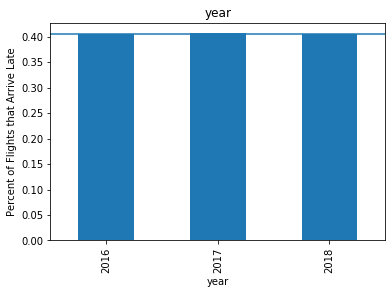

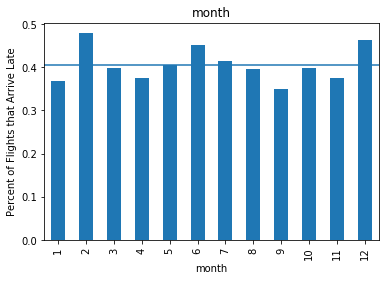

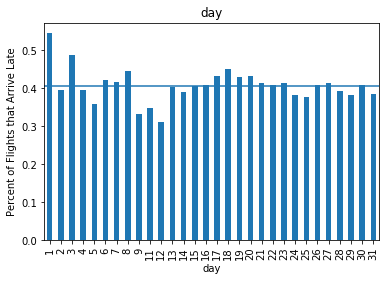

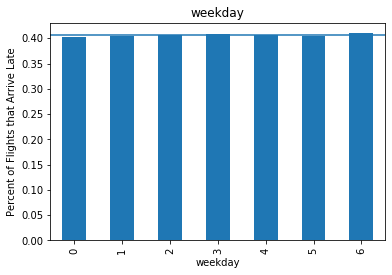

In [37]:
percent_Late = np.sum(data['RETARD'])/len(data['RETARD'])
col = ['year', 'month', 'day', 'weekday']

for i,pred in enumerate(col):
    plt.figure(i, figsize=(15, 5))
    group = data.groupby([pred], as_index=False).aggregate(np.mean)[[pred, 'RETARD']]
    group.sort_values(by=pred, inplace=True)    
    group.plot.bar(x=pred, y='RETARD')
    plt.axhline(y=percent_Late, label='Average')
    plt.ylabel('Percent of Flights that Arrive Late')
    plt.title(pred)
    plt.legend().remove()

## label encoding

In [38]:
encode = LabelEncoder()

data["AEROPORT_DEPART"] = encode.fit_transform(data["AEROPORT DEPART"])
AEROPORT_DEPART = list(encode.classes_)
data["AEROPORT_ARRIVEE"] = encode.fit_transform(data["AEROPORT ARRIVEE"])
AEROPORT_DEPART = list(encode.classes_)
data["COMPAGNIE_AERIENNE"] = encode.fit_transform(data["COMPAGNIE AERIENNE"])
COMPAGNIE_AERIENNE = list(encode.classes_)

In [39]:
data.drop([
    "AEROPORT DEPART", 
    "COMPAGNIE AERIENNE",
    "AEROPORT ARRIVEE"
], axis=1, inplace=True)#Removing original encoded columns

In [40]:
data.head()

,DEPART PROGRAMME,HEURE DE DEPART,TEMPS PROGRAMME,TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE,DISTANCE,PRIX_DEP_RP_10MIN,PRIX_DEP_RCMA_10MIN,RETARD,year,month,day,weekday,AEROPORT_DEPART,AEROPORT_ARRIVEE,COMPAGNIE_AERIENNE
0,1410,1411.0,229.0,20.0,1749,4582,586,1.0,2016,10,4,1,280,86,9
1,1455,1449.0,210.0,15.0,1325,4778,12,0.0,2018,7,16,0,201,32,4
2,1540,1607.0,235.0,9.0,1520,352,849,1.0,2018,6,1,4,288,284,8
3,2226,2219.0,84.0,14.0,337,5077,48,0.0,2016,9,1,3,38,269,12
4,1730,1719.0,71.0,14.0,252,2143,434,0.0,2016,1,23,5,302,0,7


In [41]:
data['HEURE DE DEPART'].value_counts()

555.0     7863
556.0     7364
557.0     7204
558.0     6772
655.0     6477
554.0     6277
656.0     6123
559.0     6038
657.0     5989
658.0     5802
654.0     5595
600.0     5373
659.0     5288
553.0     4988
700.0     4969
653.0     4787
755.0     4739
754.0     4342
756.0     4325
725.0     4194
757.0     4167
955.0     4137
652.0     3969
857.0     3947
1355.0    3930
753.0     3930
900.0     3928
855.0     3917
724.0     3906
959.0     3895
          ... 
358.0        7
346.0        7
436.0        7
430.0        7
412.0        7
431.0        6
422.0        6
340.0        6
345.0        6
353.0        6
440.0        6
332.0        6
331.0        6
435.0        6
351.0        5
439.0        5
434.0        5
428.0        4
343.0        4
347.0        4
337.0        4
339.0        4
403.0        3
432.0        3
441.0        3
442.0        3
338.0        3
350.0        3
433.0        2
438.0        1
Name: HEURE DE DEPART, Length: 1440, dtype: int64

In [42]:
data['TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE'].value_counts()

12.0     239090
13.0     238107
14.0     226159
11.0     220936
15.0     204845
10.0     184715
16.0     181766
17.0     158677
18.0     136730
9.0      130450
19.0     117328
20.0     100641
21.0      86032
8.0       73961
22.0      73503
23.0      62627
24.0      53317
25.0      45836
26.0      39645
27.0      33973
7.0       33162
28.0      29494
29.0      25836
30.0      22257
31.0      19595
32.0      17046
33.0      15198
6.0       13926
34.0      13318
35.0      11766
          ...  
146.0        10
156.0         9
147.0         8
161.0         7
164.0         6
152.0         5
154.0         5
155.0         5
158.0         5
160.0         5
162.0         4
170.0         3
165.0         3
171.0         3
167.0         3
172.0         2
157.0         2
168.0         2
166.0         2
163.0         2
169.0         1
175.0         1
176.0         1
177.0         1
178.0         1
179.0         1
180.0         1
181.0         1
185.0         1
200.0         1
Name: TEMPS DE DEPLACEME

In [43]:
data['TEMPS PROGRAMME'].value_counts()

90.0     29799
80.0     26884
85.0     26703
95.0     26478
110.0    24606
75.0     24506
115.0    23095
120.0    22852
76.0     22521
100.0    22321
105.0    21639
88.0     21596
94.0     21412
125.0    21246
82.0     20897
79.0     20802
87.0     20802
70.0     20770
109.0    20726
92.0     20680
77.0     20568
83.0     20543
78.0     20059
119.0    19968
93.0     19948
96.0     19899
98.0     19853
99.0     19772
113.0    19769
81.0     19644
         ...  
473.0        8
705.0        8
445.0        8
521.0        7
451.0        7
515.0        7
464.0        6
513.0        6
632.0        6
526.0        5
668.0        5
425.0        5
636.0        5
542.0        5
540.0        5
446.0        5
554.0        4
458.0        4
611.0        4
550.0        3
576.0        3
478.0        3
602.0        3
510.0        3
553.0        2
506.0        2
530.0        1
547.0        1
584.0        1
600.0        1
Name: TEMPS PROGRAMME, Length: 543, dtype: int64

La granularité des nombres dans la colonne "HEURE DE DEPART" peut avoir un impact négatif sur la précision dans un modèle Machine Learning : elle contient en effet plus de 500 valeurs uniques. Ceci peut être résolu à l’aide d’une technique appelée compartimentage ou quantification. On divise chaque nombre par 100, en arrondissant le résultat à l'entier le plus proche. Par exemple 1030 deviendra 10, 1925 deviendrait 19 et ainsi de suite, et nous aurons alors un maximum de 24 valeurs discrètes dans cette colonne.
Intuitivement, ceci a du sens, car cela importe probablement peu qu’un vol parte à 10 h 30 ou à 10 h 40. 

In [44]:
data['HEURE_DEPART'] = data['HEURE DE DEPART'].div(100).round().astype('int64')
data['DEPART_PROGRAMME'] = data['DEPART PROGRAMME'].div(100).round().astype('int64')

data.drop(["HEURE DE DEPART", "DEPART PROGRAMME"], axis=1, inplace=True) #Removing original encoded columns

data.head()

,TEMPS PROGRAMME,TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE,DISTANCE,PRIX_DEP_RP_10MIN,PRIX_DEP_RCMA_10MIN,RETARD,year,month,day,weekday,AEROPORT_DEPART,AEROPORT_ARRIVEE,COMPAGNIE_AERIENNE,HEURE_DEPART,DEPART_PROGRAMME
0,229.0,20.0,1749,4582,586,1.0,2016,10,4,1,280,86,9,14,14
1,210.0,15.0,1325,4778,12,0.0,2018,7,16,0,201,32,4,14,15
2,235.0,9.0,1520,352,849,1.0,2018,6,1,4,288,284,8,16,15
3,84.0,14.0,337,5077,48,0.0,2016,9,1,3,38,269,12,22,22
4,71.0,14.0,252,2143,434,0.0,2016,1,23,5,302,0,7,17,17


In [45]:
data.describe()

,TEMPS PROGRAMME,TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE,DISTANCE,PRIX_DEP_RP_10MIN,PRIX_DEP_RCMA_10MIN,RETARD,year,month,day,weekday,AEROPORT_DEPART,AEROPORT_ARRIVEE,COMPAGNIE_AERIENNE,HEURE_DEPART,DEPART_PROGRAMME
count,2.940415e+06,2.940415e+06,2.940415e+06,2.940415e+06,2.940415e+06,2.940415e+06,2.940415e+06,2.940415e+06,2.940415e+06,2.940415e+06,2.940415e+06,2.940415e+06,2.940415e+06,2.940415e+06,2.940415e+06
mean,1.461290e+02,1.725067e+01,8.487171e+02,5.111439e+03,4.754675e+02,4.062787e-01,2.017000e+03,6.339581e+00,1.557444e+01,3.027942e+00,1.401194e+02,1.401264e+02,7.333529e+00,1.322415e+01,1.315042e+01
std,7.920409e+01,9.256521e+00,6.447817e+02,2.714838e+03,2.791050e+02,4.911379e-01,8.163947e-01,3.403078e+00,8.878064e+00,1.993309e+00,9.626338e+01,9.624402e+01,3.033791e+00,4.966971e+00,4.865946e+00
min,1.800000e+01,1.000000e+00,3.100000e+01,1.050000e+02,1.100000e+01,0.000000e+00,2.016000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.800000e+01,1.200000e+01,3.720000e+02,2.401000e+03,2.560000e+02,0.000000e+00,2.016000e+03,3.000000e+00,7.000000e+00,1.000000e+00,6.100000e+01,6.100000e+01,5.000000e+00,9.000000e+00,9.000000e+00
50%,1.250000e+02,1.500000e+01,6.660000e+02,5.389000e+03,4.850000e+02,0.000000e+00,2.017000e+03,6.000000e+00,1.600000e+01,3.000000e+00,1.240000e+02,1.240000e+02,7.000000e+00,1.300000e+01,1.300000e+01
75%,1.790000e+02,2.000000e+01,1.091000e+03,7.791000e+03,6.950000e+02,1.000000e+00,2.018000e+03,9.000000e+00,2.300000e+01,5.000000e+00,2.400000e+02,2.400000e+02,9.000000e+00,1.700000e+01,1.700000e+01
max,7.180000e+02,2.000000e+02,4.983000e+03,9.877000e+03,9.950000e+02,1.000000e+00,2.018000e+03,1.200000e+01,3.100000e+01,6.000000e+00,3.170000e+02,3.170000e+02,1.200000e+01,2.400000e+01,2.400000e+01


# Créer les modèles de Machine Learning

Le modèle sera un modèle de classification binaire qui prédit si un vol arrivera à l’heure ou en retard (« binaire », car il n’y a que deux résultats possibles).

Pour créer un modèle Machine Learning, Nous avons besoin de deux jeux de données : un pour l’entraînement et un pour les tests.

Dans cet exercice, nous allons effectuer un fractionnement 75-25 sur notre DataFrame que vous avons préparé précédent, afin de pouvoir l’utiliser pour entraîner un modèle Machine Learning. Nous allons aussi séparer le DataFrame en colonnes de caractéristiques et en colonnes d’étiquettes. Le premier contient les colonnes utilisées comme entrée pour le modèle (par exemple l’aéroport d'arrivée, l'aéroport de départ, et l’heure de départ planifiée), tandis que le deuxième contient la colonne que le modèle va essayer de prédire : dans ce cas, la colonne Retard de départ, qui indique si un vol arrivera à l’heure.

In [46]:
# Getting the output variable
y = data['RETARD']
# Getting the input variables
X = data.drop(['RETARD', 'year', 'weekday'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, 
                                    test_size=0.25,
                                    random_state=42)

In [47]:
print(f'Nombre de lignes et de colonnes de X_train : {X_train.shape}')
print(f'Nombre de lignes et de colonnes de X_test : {X_test.shape}')

Nombre de lignes et de colonnes de X_train : (2205311, 12)
Nombre de lignes et de colonnes de X_test : (735104, 12)


Nous utiliserons le RandomForestClassifier, qui ajuste plusieurs arbres de décision aux données, et utilise la moyenne pour améliorer la précision globale et limiter le surajustement.

## Random Forest

Nous utiliserons le RandomForestClassifier, qui ajuste plusieurs arbres de décision aux données, et utilise la moyenne pour améliorer la précision globale et limiter le surajustement.

- n_estimators : plus il y a d'arbres, moins l'algorithme a de chances de s'ajuster. Plus ce nombre est faible, plus le modèle est proche d'un arbre de décision, avec un ensemble de fonctionnalités restreint.
- max_features : On doit essayer de réduire ce nombre. Cela définit le nombre d'entités attribuées au hasard à chaque arbre. 
- max_depth : ce paramètre réduira la complexité des modèles appris, réduisant ainsi le risque d'ajustement. 
- min_samples_leaf : On essaie de définir ces valeurs supérieures à un. Cela a un effet similaire au paramètre max_depth, cela signifie que la branche cessera de se séparer une fois que les feuilles auront ce nombre d'échantillons chacune.

In [48]:
clf = RandomForestClassifier(n_estimators=20, max_depth=20, min_samples_leaf=10, random_state=42,
                             min_samples_split=4, max_features='auto', warm_start=True)
clf.fit(X_train, y_train)
print(f"Accuracy on training set : {clf.score(X_train, y_train)}")
print(f"Accuracy on test set : {clf.score(X_test, y_test)}")

Accuracy on training set : 0.7670596120003029
Accuracy on test set : 0.7441994602124326


#### AUC

In [49]:
probabilities = clf.predict_proba(X_test)
roc_auc_score(y_test, probabilities[:, 1])

0.7925601572628543

#### Matrice de confusion

In [52]:
y_preds = clf.predict(X_test)
confusion_matrix(y_test, y_preds)

array([[400424,  36721],
       [151319, 146640]], dtype=int64)

#### Précision

In [53]:
train_predictions = clf.predict(X_train)
precision_score(y_train, train_predictions)

0.8463653449245792

#### Courbe de ROC

Text(0, 0.5, 'True Positive Rate')

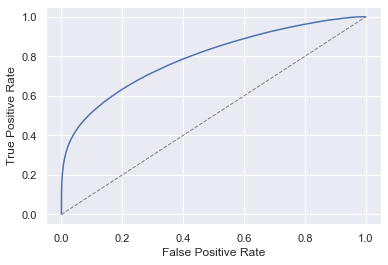

In [54]:
sns.set()

fpr, tpr, _ = roc_curve(y_test, probabilities[:, 1])
#fig = plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# LogisticRegression

In [55]:
logreg = LogisticRegression(max_iter=10000, random_state=42)
logreg.fit(X_train, y_train)
print(f"Accuracy on training set : {logreg.score(X_train, y_train)}")
print(f"Accuracy on test set : {logreg.score(X_test, y_test)}")

Accuracy on training set : 0.6919405018158437
Accuracy on test set : 0.6919932417725927


#### AUC

In [56]:
probabilities = logreg.predict_proba(X_test)
roc_auc_score(y_test, probabilities[:, 1])

0.7168027633467902

#### Matrice de confusion

In [57]:
y_preds = logreg.predict(X_test)
confusion_matrix(y_test, y_preds)

array([[403835,  33310],
       [193107, 104852]], dtype=int64)

#### Précision

In [ ]:
train_predictions = logreg.predict(X_train)
precision_score(y_train, train_predictions)

#### Courbe de ROC

In [ ]:
sns.set()

fpr, tpr, _ = roc_curve(y_test, probabilities[:, 1])
#fig = plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## La mise en application de notre modèle 

In [240]:
def predict_delay(departure_date_time, origin, destination):
    
    from datetime import datetime

    try:
        departure_date_time_parsed = datetime.strptime(departure_date_time, '%d/%m/%Y %H:%M:%S')
    except ValueError as e:
        return 'Error parsing date/time - {}'.format(e)

    month = departure_date_time_parsed.month
    day = departure_date_time_parsed.day
    day_of_week = departure_date_time_parsed.isoweekday()
    hour = departure_date_time_parsed.hour

    origin = origin.upper()
    destination = destination.upper()

    input = [{'MONTH': month,
              'DAY': day,
              'DAY_OF_WEEK': day_of_week,
              'TIME': hour,
              'ORIGIN_DSS': 1 if origin == 'DSS' else 0,
              'ORIGIN_BOH': 1 if origin == 'BOH' else 0,
              'ORIGIN_TNA': 1 if origin == 'TNA' else 0,
              'ORIGIN_SXF': 1 if origin == 'SXF' else 0,
              'DEST_DSS': 1 if destination == 'DSS' else 0,
              'DEST_BOH': 1 if destination == 'BOH' else 0,
              'DEST_TNA': 1 if destination == 'TNA' else 0,
              'DEST_SXF': 1 if destination == 'SXF' else 0
             }]

    return clf.predict_proba(pd.DataFrame(input))[0][0]

Cette fonction prend en entrée une date/heure, un code d’aéroport d’origine et un code d’aéroport de destination, et elle retourne une valeur entre 0,0 et 1,0 qui indique la probabilité que le vol arrive à l’heure à sa destination. Il utilise le modèle Machine Learning que nous avons créé dans le labo précédent pour calculer la probabilité. Pour appeler le modèle, elle passe un DataFrame contenant les valeurs d’entrée à predict_proba. La structure du DataFrame correspond exactement à la structure du DataFrame que nous avons utilisé précédemment.

Utilisons le code ci-dessous pour calculer la probabilité qu’un vol de Bournemouth à Dakar-Blaise Diagne le soir du 1er octobre arrive à l’heure. L’année que vous entrez est sans importance, car elle n’est pas utilisée par le modèle.

In [241]:
predict_delay('1/10/2018 21:45:00', 'BOH', 'DSS')

0.7954421313595008

probabilité d’une arrivée à l’heure est de 79%

Modifiez le code pour calculer la probabilité que le même vol 20 jour plus tard arrive à l’heure

In [213]:
predict_delay('20/10/2018 21:45:00', 'BOH', 'DSS')

0.7497297253033742

### Probabilité des arrivées à l’heure pour un vol le soir de BOH à DSS sur une plage de jours

(0.0, 1.0)

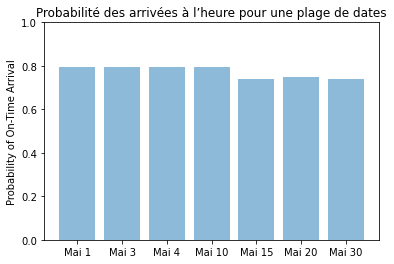

In [223]:
labels = ('Mai 1', 'Mai 3', 'Mai 4', 'Mai 10', 'Mai 15', 'Mai 20', 'Mai 30')
values = (predict_delay('1/05/2018 20:45:00', 'BOH', 'DSS'),
          predict_delay('3/05/2018 20:45:00', 'BOH', 'DSS'),
          predict_delay('4/05/2018 20:45:00', 'BOH', 'DSS'),
          predict_delay('10/05/2018 20:45:00', 'BOH', 'DSS'),
          predict_delay('15/05/2018 20:45:00', 'BOH', 'DSS'),
          predict_delay('20/05/2018 20:45:00', 'BOH', 'DSS'),
          predict_delay('30/05/2018 20:45:00', 'BOH', 'DSS'))

alabels = np.arange(len(labels))
plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.title('Probabilité des arrivées à l’heure pour une plage de dates')
plt.ylim((0.0, 1.0))

(0.0, 1.0)

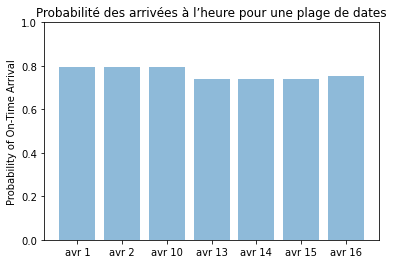

In [228]:
labels = ('avr 1', 'avr 2', 'avr 10', 'avr 13', 'avr 14', 'avr 15', 'avr 16')
values = (predict_delay('1/04/2018 13:00:00', 'BOH', 'SXF'),
          predict_delay('2/04/2018 13:00:00', 'BOH', 'SXF'),
          predict_delay('10/04/2018 13:00:00', 'BOH', 'SXF'),
          predict_delay('13/04/2018 13:00:00', 'BOH', 'SXF'),
          predict_delay('14/04/2018 13:00:00', 'BOH', 'SXF'),
          predict_delay('15/04/2018 13:00:00', 'BOH', 'SXF'),
          predict_delay('16/04/2018 13:00:00', 'BOH', 'SXF'))
alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.title('Probabilité des arrivées à l’heure pour une plage de dates')
plt.ylim((0.0, 1.0))

(0.0, 1.0)

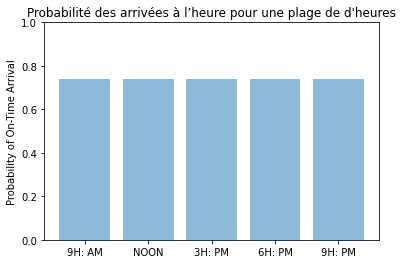

In [235]:
labels = ('9H: AM', 'NOON', '3H: PM', '6H: PM', '9H: PM',)

values = (predict_delay('30/01/2018 09:00:00', 'TNA', 'BOH'),
          predict_delay('30/01/2018 12:00:00', 'TNA', 'BOH'),
          predict_delay('30/01/2018 15:00:00', 'TNA', 'BOH'),
          predict_delay('30/01/2018 18:00:00', 'TNA', 'BOH'),
          predict_delay('30/01/2018 21:00:00', 'TNA', 'BOH'))

alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.title("Probabilité des arrivées à l’heure pour une plage de d'heures")
plt.ylim((0.0, 1.0))

## application opérationnelle - coût


In [67]:
moy_prix = df[["AEROPORT DEPART", "RETART DE DEPART","PRIX_DEP_RP_10MIN", "PRIX_DEP_RCMA_10MIN"]]
moy_prix = moy_prix[moy_prix["RETART DE DEPART"] > 0]
moy_prix = moy_prix.loc[(moy_prix["AEROPORT DEPART"] == "SHJ") | (moy_prix["AEROPORT DEPART"] == "AGP") ]
moy_prix = moy_prix.groupby('AEROPORT DEPART') \
       .agg({'AEROPORT DEPART':'size', 'PRIX_DEP_RP_10MIN':'mean', 'PRIX_DEP_RCMA_10MIN':'mean', 'RETART DE DEPART':'mean'}) \
       .rename(columns={'AEROPORT DEPART':'num_retart','PRIX_DEP_RP_10MIN':'prix_inf_10min', 'PRIX_DEP_RCMA_10MIN':'prix_sup_10min', 
                        'RETART DE DEPART':'retard_moyen'  }) \
       .reset_index()
moy_prix.sort_values(by='num_retart', ascending=False)

,AEROPORT DEPART,num_retart,prix_inf_10min,prix_sup_10min,retard_moyen
1,SHJ,87161,8241,341,37.143264
0,AGP,79593,771,143,29.146709


# Cartographie

In [38]:
df.head()

,AEROPORT ARRIVEE,AEROPORT DEPART,DEPART PROGRAMME,HEURE DE DEPART,RETART DE DEPART,TEMPS PROGRAMME,TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE,DISTANCE,DATE,COMPAGNIE AERIENNE,PRIX_DEP_RP_10MIN,PRIX_DEP_RCMA_10MIN
0,DSS,TIA,1410,1411.0,1.0,229.0,20.0,1749,10/4/2016,NVPPA,4582,586
1,BOH,MPM,1455,1449.0,-6.0,210.0,15.0,1325,16/7/2018,COA,4778,12
2,TNA,TRN,1540,1607.0,27.0,235.0,9.0,1520,6/1/2018,NA,352,849
3,SXF,BRU,2226,2219.0,-7.0,84.0,14.0,337,9/1/2016,THA,5077,48
4,AAL,VCE,1730,1719.0,-11.0,71.0,14.0,252,23/1/2016,MAF,2143,434


In [39]:
df.columns

Index(['AEROPORT ARRIVEE', 'AEROPORT DEPART', 'DEPART PROGRAMME',
       'HEURE DE DEPART', 'RETART DE DEPART', 'TEMPS PROGRAMME',
       'TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE', 'DISTANCE', 'DATE',
       'COMPAGNIE AERIENNE', 'PRIX_DEP_RP_10MIN', 'PRIX_DEP_RCMA_10MIN'],
      dtype='object')

In [48]:
moy_dep = df[["AEROPORT DEPART", "RETART DE DEPART"]]
moy_dep = moy_dep[moy_dep["RETART DE DEPART"] > 0]
moy_dep = moy_dep.groupby('AEROPORT DEPART') \
       .agg({'AEROPORT DEPART':'size', 'RETART DE DEPART':'mean'}) \
       .rename(columns={'AEROPORT DEPART':'num_retart','RETART DE DEPART':'retard_moyen'}) \
       .reset_index()
moy_dep.sort_values(by='num_retart', ascending=False)



,AEROPORT DEPART,num_retart,retard_moyen
250,SHJ,87161,37.143264
7,AGP,79593,29.146709
92,DXB,68902,33.293707
201,MPM,43796,32.879258
38,BRU,43702,31.208000
124,HAN,43284,32.363529
269,SXF,37904,34.163571
67,CTU,30478,35.081108
284,TNA,26018,28.700938
163,KWL,25380,37.762687


In [45]:
col_to_keep = ['CODE IATA', 
               'LONGITUDE', 
               'LATITUDE']

df_coord = df_aeroports[col_to_keep]

long = df_coord.iloc[:,:-1].set_index(
        'CODE IATA').to_dict()['LONGITUDE']

lat = df_coord.loc[:,['CODE IATA',
        'LATITUDE']].set_index(
        'CODE IATA').to_dict()['LATITUDE']

In [46]:
moy_dep["lat"] = moy_dep['AEROPORT DEPART'].apply(lambda x : lat[x])
moy_dep["long"] = moy_dep['AEROPORT DEPART'].apply(lambda x : long[x])

moy_dep.head()

,AEROPORT DEPART,num_retart,retard_moyen,lat,long
0,AAL,22971,30.816551,57.0927589138,9.84924316406
1,AAP,322,51.934783,-0.374448,117.249392
2,ABV,1670,45.513174,9.006790161132812,7.263169765472412
3,ACC,130,40.323077,5.605189800262451,-0.16678600013256073
4,ADB,132,49.128788,38.2924003601,27.156999588


In [47]:
!pip install plotly
import plotly.graph_objects as go

import pandas as pd

moy_dep['text'] = moy_dep['AEROPORT DEPART'] + ''  + 'Retart: ' + moy_dep['retard_moyen'].astype(str)

fig = go.Figure(data=go.Scattergeo(
        lon = moy_dep['long'],
        lat = moy_dep['lat'],
        text = moy_dep['text'],
        mode = 'markers',
        marker_color = moy_dep['retard_moyen'],
        ))

fig.update_layout(
        title = 'Retard moyen au départ de chaque aéroport')
fig.show()